# Imports
besides the usual imports we also need the tensorflow hub

In [22]:
import tensorflow as tf
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import os
import datetime

import keras
from tensorflow.keras import layers

import PIL.Image as Image


# Use tensorflow hub mobilenet v3 for predictions

In [3]:
IMAGE_RES = 224

KERAS_URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2"
# Setup the model


model = tf.keras.Sequential([
    hub.KerasLayer(KERAS_URL,
        input_shape=(IMAGE_RES,IMAGE_RES,3))
])

# Run it on a single image

65536/61306 [================================] - 0s 0us/step


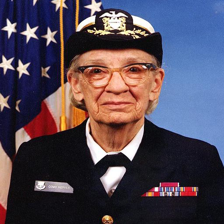

In [4]:
grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize((IMAGE_RES, IMAGE_RES))
grace_hopper 

# View and decode the predictions

In [5]:
grace_hopper = np.array(grace_hopper)/255.0

result = model.predict(grace_hopper[np.newaxis, ...])

predicted_class = np.argmax(result[0], axis=-1)


16384/10484 [==============================================] - 0s 0us/step


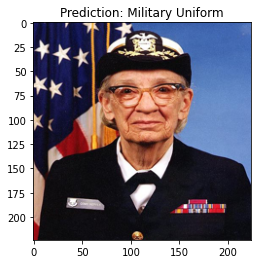

In [6]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

plt.imshow(grace_hopper)

predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())

# Lets try it on a sample of my images

## Now lets try it on the cats and dogs Dataset



---
# First lets import the dataset

### We can use the tensorflow datasets to load it



In [7]:
(train_examples, validation_examples) , info = tfds.load(
    'cats_vs_dogs',
    with_info = True,
    as_supervised = True,
    split=['train[:80%]','train[80%:]'],
)

num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes

Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteV8PCPC/cats_vs_dogs-train.tfrecord


Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


In [8]:
for i, example_image in enumerate(train_examples.take(3)):
  print("Image {} shape: {}".format(i+1,example_image[0].shape))

Image 1 shape: (262, 350, 3)
Image 2 shape: (409, 336, 3)
Image 3 shape: (493, 500, 3)


#### So we need to make every image into a 224 224 3 size
so lets make a simple function

In [9]:
def format_image(image, label):
  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
  return image, label

BATCH_SIZE = 32

# Setup train and validation bathes
train_batches      = train_examples.shuffle(num_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_examples.map(format_image).batch(BATCH_SIZE).prefetch(1)

# Lets run the classifier on a batch of images

* Remember our model has not yet been trained on our images but the mobile net still has 1000 possible output classes.

In [10]:
image_batch , label_batch = next(iter(train_batches.take(1)))
image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

result_batch = model.predict(image_batch)

predicted_class_name = imagenet_labels[np.argmax(result_batch,axis=-1)]

# Print out the predicted class names
predicted_class_name

array(['Siamese cat', 'miniature poodle', 'Siamese cat', 'Chihuahua',
       'lynx', 'Egyptian cat', 'Siberian husky', 'Siamese cat',
       'Egyptian cat', 'tabby', 'tabby', 'tabby', 'chow', 'Egyptian cat',
       'tabby', 'guinea pig', 'miniature poodle', 'tiger cat', 'tabby',
       'Bernese mountain dog', 'tabby', 'Egyptian cat',
       'Labrador retriever', 'Egyptian cat', 'EntleBucher',
       'Labrador retriever', 'flat-coated retriever',
       'miniature pinscher', 'Persian cat', 'Egyptian cat', 'Siamese cat',
       'tabby'], dtype='<U30')

We have viewed the labels of the images now lets plot some images and see the results

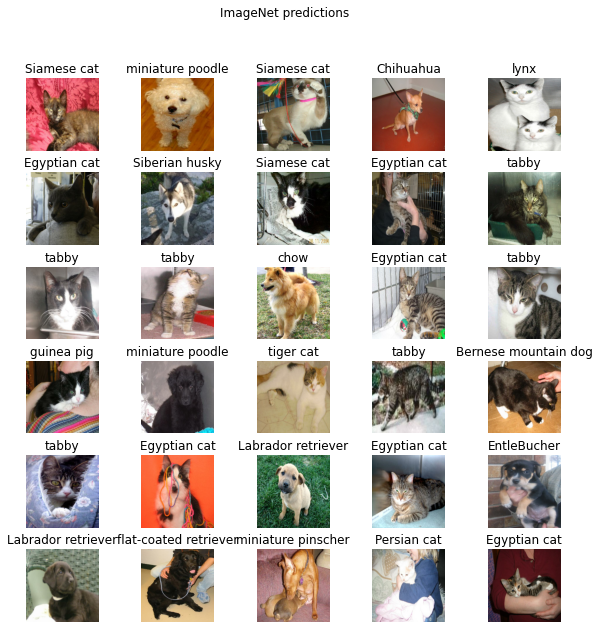

In [11]:
plt.figure(figsize=(10,10))

for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_name[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

# Now lets do a simple transfer learning with tensorflow hub



In [12]:
KERAS_URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2"

feature_extractor = hub.KerasLayer(KERAS_URL,
                                   input_shape=(IMAGE_RES,IMAGE_RES,3))

In [13]:
feature_batch = feature_extractor(image_batch)

print(feature_batch.shape)

(32, 1280)


Freeze the variables in the feature extractor layer , so that the training only modifies the finlas classifier layer (our layer)

In [14]:
feature_extractor.trainable = False

# Attach a classification head

In [15]:
model = tf.keras.Sequential([
        feature_extractor,
        layers.Dense(2 ,activation="softmax")
])

# View model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


# Train the model

In [29]:
%%time

model.compile(
    optimizer ='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics= ['accuracy']
)

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

EPOCHS = 100

history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data = validation_batches,
                    callbacks = [callback])


Epoch 1/100
582/582 [==============================] - 38s 57ms/step - loss: 0.0012 - accuracy: 0.9999 - val_loss: 0.0620 - val_accuracy: 0.9890
Epoch 2/100
582/582 [==============================] - 37s 56ms/step - loss: 7.9139e-04 - accuracy: 0.9999 - val_loss: 0.0681 - val_accuracy: 0.9873
Epoch 3/100
582/582 [==============================] - 37s 56ms/step - loss: 0.0018 - accuracy: 0.9996 - val_loss: 0.0648 - val_accuracy: 0.9886
CPU times: user 3min 10s, sys: 11.3 s, total: 3min 22s
Wall time: 1min 51s


Max Training accuracy:  0.9999462366104126
Max Validation accuracy:  0.9890369772911072


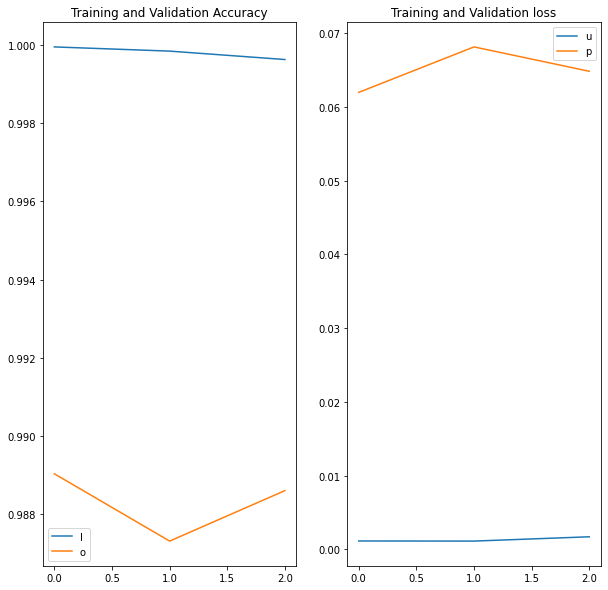

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

print("Max Training accuracy: ",max(acc))
print("Max Validation accuracy: ",max(val_acc))

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.plot(epochs_range,acc,label='Training accuracy')
plt.plot(epochs_range,val_acc,label='Validation accuracy')
plt.legend('lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(epochs_range,loss,label='Training loss')
plt.plot(epochs_range,val_loss,label='Validation loss')
plt.legend('upper right')
plt.title('Training and Validation loss')

plt.show()

# Lets check the predictions

In [31]:
class_names = np.array(info.features['label'].names)
class_names

array(['cat', 'dog'], dtype='<U3')

# Lets look at the predicted images

In [32]:
predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()

predicted_ids = np.argmax(predicted_batch,axis=1)

predicted_class_names = class_names[predicted_ids]
predicted_class_names

array(['cat', 'dog', 'cat', 'dog', 'cat', 'cat', 'dog', 'cat', 'cat',
       'cat', 'cat', 'cat', 'dog', 'cat', 'cat', 'cat', 'dog', 'cat',
       'cat', 'cat', 'cat', 'cat', 'dog', 'cat', 'dog', 'dog', 'dog',
       'dog', 'cat', 'cat', 'cat', 'cat'], dtype='<U3')

Now lets plot the images

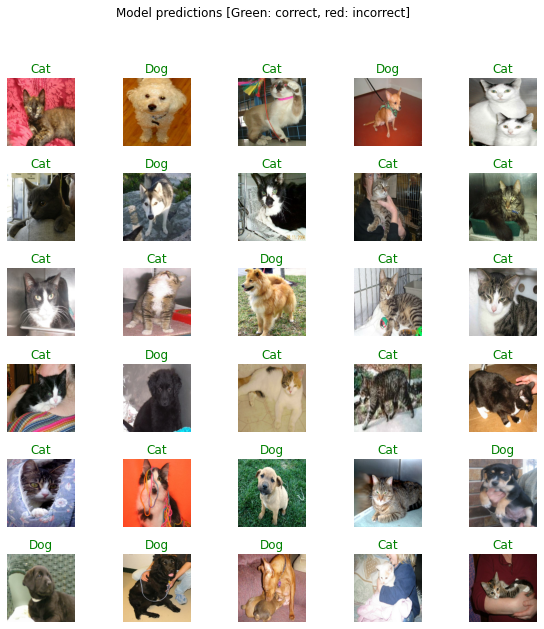

In [33]:
plt.figure(figsize=(10,10))

for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace=0.4)
  plt.imshow(image_batch[n])
  color = 'green' if predicted_ids[n] == label_batch[n] else 'red'
  plt.title(predicted_class_names[n].title(),color=color)
  plt.axis('off')
  _= plt.suptitle('Model predictions [Green: correct, red: incorrect]')